# Business Problem

The Buffalo Sabres have recently shown promising performance and are expected to do even better next year. In light of this, the team's General Manager, Kevyn Adams, has requested the assistance of a data scientist to conduct a comprehensive analysis of the team's offense and defense, with the ultimate goal of identifying areas for improvement.

Given the recent acquisition of goaltender Devon Levi, our analysis will focus exclusively on the team's offense and defense. As a data scientist, my role in this project is to leverage statistical techniques and machine learning algorithms to identify key trends and patterns in the Sabres' performance data. Based on this analysis, I will develop actionable recommendations that can be used by the team's coaching staff and management to improve their performance on the ice.

Throughout the course of this project, I will be using advanced statistical analysis to identify key trends and patterns in the Buffalo Sabres' performance data. Specifically, I will be using data from moneypuck.com, a leading sports analytics website that provides detailed statistics and insights on NHL teams and players. By taking a collaborative and data-driven approach, we can uncover insights and opportunities that will help the Sabres achieve their goals and continue to build on their recent success.


since the team is young we want to focus on player development.
focus on defense as a whole, and offense as another.
identify which we need to focus on more.
make recommendations on that.
are there any players we should cut ties with?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
shots_df = pd.read_csv('shots_2022.csv')
buffalo_df = pd.read_csv('BUF.csv')
buffalo_player_stats = pd.read_csv('buf_player_stats.csv')
boston_player_stats = pd.read_csv('BOS.csv')
boston_df = pd.read_csv('BOS_team_stats.csv')

# Identifying The Sabres weakness
The sabres are a little time away from being a serious threat, but with such a young team they have time to grow.  To identify weaknesses, we will compare them with a team that is a serious contender for the stanley cup this year. The Boston Bruins.

I only want to focus on the most current season, the 2022 season. I will 

In [3]:
buffalo_2022 = buffalo_df[buffalo_df['season'] == 2022]

In [4]:
boston_df['gameId'] = boston_df['gameId'].astype(str)
boston_2022 = boston_df[boston_df['gameId'].str[:4] == '2022']

Both boston and buffalo have their own dfs that focus on the current (2022) season

A big offensive metric in the NHL is corsi.  Corsi is a statistic used in ice hockey that measures shot attempt differential, which is the difference in the number of shots taken by a team and the number of shots taken against them during a game or over a period of time. It includes shots on goal, missed shots, and blocked shots. Corsi is often used as an indicator of possession and can be used to evaluate a team's overall performance and the effectiveness of individual players.  In this current section we will be analyzing the corsi between one of the leagues best team, and the sabres.

In [5]:
boston_corsi = boston_player_stats.loc[:, boston_player_stats.columns.str.contains('corsi|Corsi|goal|name|situation')]

In [6]:
boston_corsi

,name,situation,onIce_corsiPercentage,offIce_corsiPercentage,I_F_goals,OnIce_F_goals,OnIce_A_goals,corsiForAfterShifts,corsiAgainstAfterShifts
0,Jakub Zboril,other,0.3333,0.0000,0.0,1.0,0.0,0.0,0.0
1,Jakub Zboril,all,0.4750,0.4156,0.0,2.0,0.0,0.0,0.0
2,Jakub Zboril,5on5,0.5294,0.4259,0.0,1.0,0.0,1.0,0.0
3,Jakub Zboril,4on5,0.0000,0.1818,0.0,0.0,0.0,1.0,0.0
4,Jakub Zboril,5on4,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
6115,Mike Reilly,other,1.0000,0.1818,0.0,0.0,0.0,1.0,0.0
6116,Mike Reilly,all,0.4167,0.6222,0.0,0.0,1.0,0.0,0.0
6117,Mike Reilly,5on5,0.3913,0.6774,0.0,0.0,1.0,2.0,1.0
6118,Mike Reilly,4on5,0.0000,0.2857,0.0,0.0,0.0,0.0,0.0


In [7]:
boston_corsi_situation_mean = boston_corsi.groupby('situation')['onIce_corsiPercentage'].mean()
print(boston_corsi_situation_mean)

situation
4on5     0.120080
5on4     0.451975
5on5     0.506919
all      0.511511
other    0.229584
Name: onIce_corsiPercentage, dtype: float64


In [8]:
buffalo_corsi = buffalo_player_stats.loc[:, buffalo_player_stats.columns.str.contains('corsi|Corsi|goal|name|situation')]

In [9]:
buffalo_corsi_situation_mean = buffalo_corsi.groupby('situation')['onIce_corsiPercentage'].mean()
print(buffalo_corsi_situation_mean)

situation
4on5     0.079646
5on4     0.436941
5on5     0.513409
all      0.512356
other    0.211848
Name: onIce_corsiPercentage, dtype: float64


The above print outs are the average corsi for each team, in each situation.
The Bruins are undoubtedly better while killing a penalty (4on5).
Bruins are better again while on the powerplay (5on4)
5 on 5 the sabres have a good full strength (5on5) so their overall average is better, however this shows that special teams needs some work. When the sabres are up a player, theyre allowing too many shots, wasting the man advantage. A powerplay should be all out attack. 

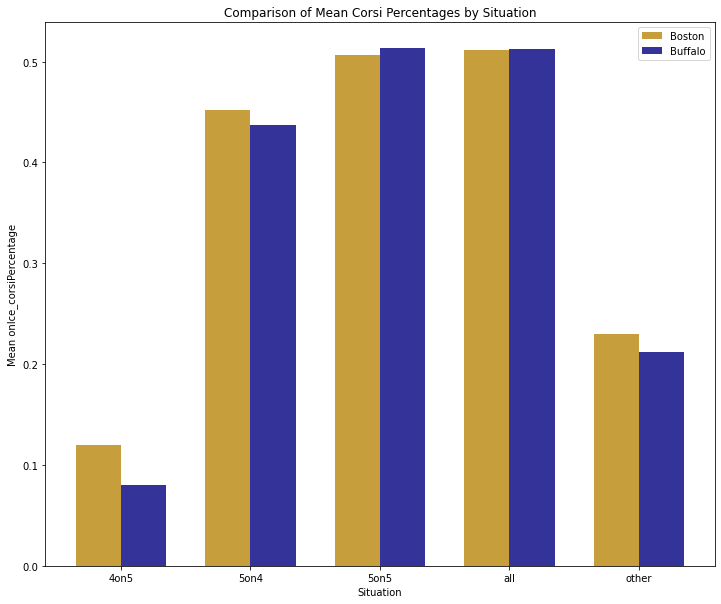

In [11]:
# Get mean corsi percentages by situation for Boston and Buffalo
boston_corsi_situation_mean = boston_corsi.groupby('situation')['onIce_corsiPercentage'].mean()
buffalo_corsi_situation_mean = buffalo_corsi.groupby('situation')['onIce_corsiPercentage'].mean()

# Set up the bar graph
fig, ax = plt.subplots(figsize=(12, 10))
bar_width = 0.35
opacity = 0.8

# Set x-axis labels and positions
labels = boston_corsi_situation_mean.index
x_pos = np.arange(len(labels))

# Create the bar graph
rects1 = ax.bar(x_pos, boston_corsi_situation_mean, bar_width,
                alpha=opacity, color='darkgoldenrod',
                label='Boston')
rects2 = ax.bar(x_pos + bar_width, buffalo_corsi_situation_mean, bar_width,
                alpha=opacity, color='navy',
                label='Buffalo')

# Add labels, title, and legend to the graph
ax.set_xlabel('Situation')
ax.set_ylabel('Mean onIce_corsiPercentage')
ax.set_title('Comparison of Mean Corsi Percentages by Situation')
ax.set_xticks(x_pos + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

# Show the graph
plt.show()

# Improving special teams corsi.

I'd like to recommend a new for each situation in which we are struggling that will improve overall corsi (the difference in the number of shots taken by a team and the number of shots taken against them).

### Focusing on the power  play first (5 on 4)

In [18]:
buffalo_corsi_5on4 = buffalo_corsi[buffalo_corsi['situation'] == '5on4']

In [19]:
buffalo_corsi_5on4

,name,situation,onIce_corsiPercentage,offIce_corsiPercentage,I_F_goals,OnIce_F_goals,OnIce_A_goals,corsiForAfterShifts,corsiAgainstAfterShifts
4,Jacob Bryson,5on4,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
9,Jacob Bryson,5on4,0.0,0.7143,0.0,0.0,0.0,0.0,0.0
14,Jacob Bryson,5on4,0.0,1.0000,0.0,0.0,0.0,0.0,0.0
19,Jacob Bryson,5on4,0.0,0.6923,0.0,0.0,0.0,0.0,0.0
24,Jacob Bryson,5on4,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
6094,Mattias Samuelsson,5on4,0.0,0.7500,0.0,0.0,0.0,0.0,0.0
6099,Mattias Samuelsson,5on4,0.0,0.7500,0.0,0.0,0.0,0.0,0.0
6104,Mattias Samuelsson,5on4,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
6109,Riley Sheahan,5on4,0.0,0.0000,0.0,0.0,0.0,0.0,0.0


In [30]:

# Sort by average onIce_corsiPercentage and select top 5 players
top_5_players = player_corsi_avg.sort_values('onIce_corsiPercentage', ascending=False).head(5)

# Calculate mean corsi for the top 5 players
mean_corsi_top_5 = top_5_players['onIce_corsiPercentage'].mean()

# Convert top 5 players to a list
top_5_players = top_5_players['name'].tolist()

print("Top 5 players for 5 on 4 situation: ", top_5_players)
print("Mean corsi for the top 5 players: ", mean_corsi_top_5)

Top 5 players for 5 on 4 situation:  ['Tage Thompson', 'Jeff Skinner', 'Rasmus Dahlin', 'Alex Tuch', 'Dylan Cozens']
Mean corsi for the top 5 players:  0.8589397358118906


In [27]:
# Calculate average onIce_corsiPercentage for each player
player_corsi_avg = buffalo_corsi_5on4.groupby('name')['onIce_corsiPercentage'].mean().reset_index()

# Sort by average onIce_corsiPercentage and select top 5 players
top_5_players = player_corsi_avg.sort_values('onIce_corsiPercentage', ascending=False).head(5)['name'].tolist()

# Exclude top 5 players from consideration and repeat same steps
player_corsi_avg = player_corsi_avg[~player_corsi_avg['name'].isin(top_5_players)]
second_best_5_players = player_corsi_avg.sort_values('onIce_corsiPercentage', ascending=False).head(5)

# Calculate mean corsi for the second best line of 5 players
mean_corsi = second_best_5_players['onIce_corsiPercentage'].mean()

# Print the list of player names, their average corsi, and the mean corsi for the line
print("Second best line of 5 players:")
print(second_best_5_players[['name', 'onIce_corsiPercentage']])
print(f"Mean Corsi for the second best line of 5 players: {mean_corsi:.2f}")

Second best line of 5 players:
                 name  onIce_corsiPercentage
25    Victor Olofsson               0.735620
3   Casey Mittelstadt               0.690028
17         Owen Power               0.608400
8          Jack Quinn               0.557615
7          JJ Peterka               0.514478
Mean Corsi for the second best line of 5 players: 0.62


Now I'd like to show what a better corsi number will do for our goal total.

Correlation between onIce_corsiPercentage and OnIce_F_goals: 0.46


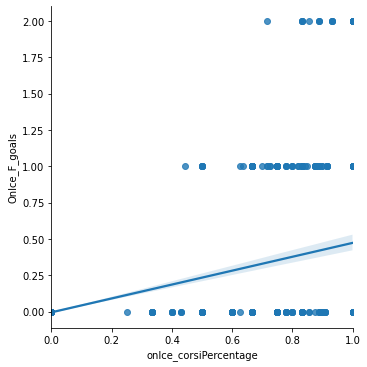

In [33]:
# Load data and create scatter plot with regression line
sns.lmplot(x='onIce_corsiPercentage', y='OnIce_F_goals', data=buffalo_corsi_5on4)

# Calculate correlation
corr = buffalo_corsi_5on4['onIce_corsiPercentage'].corr(buffalo_corsi_5on4['OnIce_F_goals'])
print(f"Correlation between onIce_corsiPercentage and OnIce_F_goals: {corr:.2f}")

 the correlation coefficient between corsi and being on the icde for a goal is 0.46, which indicates a positive relationship between the two variables. This means that as the corsi increases, the amount of goals scored tend to increase as well, and vice versa.

# Predicting how well this line can do over the length of 82 games.

In [40]:
# Create a new DataFrame with rows containing only top 5 players and situation as 5on4
buffalo_corsi_5on4_top5 = buffalo_player_stats[(buffalo_player_stats['name'].isin(top_5_players)) & (buffalo_player_stats['situation'] == '5on4')]


buffalo_corsi_5on4_top5

,playerId,name,gameId,playerTeam,opposingTeam,home_or_away,gameDate,position,situation,icetime,...,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts
624,8481528,Dylan Cozens,2022020013,BUF,OTT,HOME,20221013,C,5on4,239.0,...,0.062,0.236,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
629,8481528,Dylan Cozens,2022020025,BUF,FLA,HOME,20221015,C,5on4,129.0,...,0.134,0.108,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
634,8481528,Dylan Cozens,2022020054,BUF,EDM,AWAY,20221018,C,5on4,192.0,...,0.940,0.000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
639,8481528,Dylan Cozens,2022020068,BUF,CGY,AWAY,20221020,C,5on4,248.0,...,0.789,0.042,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
644,8481528,Dylan Cozens,2022020084,BUF,VAN,AWAY,20221022,C,5on4,0.0,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954,8479420,Tage Thompson,2022021025,BUF,DAL,HOME,20230309,C,5on4,118.0,...,0.032,0.062,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3959,8479420,Tage Thompson,2022021040,BUF,NYR,HOME,20230311,C,5on4,134.0,...,0.043,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3964,8479420,Tage Thompson,2022021061,BUF,TOR,AWAY,20230313,C,5on4,210.0,...,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3969,8479420,Tage Thompson,2022021076,BUF,WSH,AWAY,20230315,C,5on4,133.0,...,0.008,0.010,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
